In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Let's assume you have this:
# df_labeled: DataFrame with features + 'label' column
# df_unlabeled: DataFrame with the same features, but no labels

df = pd.read_csv("ML-water/AllData.csv")
df.set_index("CVEGEO", inplace=True)
df = df.drop(labels=["NOM_ENT","NOM_MUN"], axis = 1)



# normalized data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=["semaforo"]))
                          
X_scaled_df = pd.DataFrame(X_scaled, index=df.index, columns=df.drop(columns=["semaforo"]).columns)
X_scaled_df['semaforo'] = df['semaforo']

X_labeled = X_scaled_df[X_scaled_df["semaforo"].notna()]
y = X_labeled['semaforo']
X_labeled.drop(labels = "semaforo", axis = 1, inplace=True)
X_unlabeled = X_scaled_df[X_scaled_df["semaforo"].isna()]
X_unlabeled.drop(labels = "semaforo", axis = 1, inplace=True)


# y encoded
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = pd.DataFrame(y_encoded, index=X_labeled.index, columns=['semaforo_encoded'])
y_encoded = y_encoded.astype(int)
y_df = pd.DataFrame(y_encoded, index=y.index, columns=['semaforo_encoded'])
y_df["semaforo_encoded"] = y_df["semaforo_encoded"].replace(3, -1)

x_train, x_test, y_train, y_test = train_test_split(X_labeled, y_df, test_size=0.2, random_state=42, stratify=y_df)

print(x_train.shape, y_train.shape)

# View the mapping
for index, label in enumerate(le.classes_):
    print(f"{label} → {index}")


models = [CatBoostClassifier(iterations=500, class_weights={1: 0.31, 0: 0.42, 2: .27}, verbose=0),
        XGBClassifier(max_depth=5, reg_alpha=1),
        RandomForestClassifier(max_samples=0.5, class_weight={1: 0.31, 0: 0.42, 2: .27})
]

(836, 12) (836, 1)
Amarillo → 0
Rojo → 1
Verde → 2


C:\Users\amvc6\AppData\Local\Temp\ipykernel_30492\2799603673.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_labeled.drop(labels = "semaforo", axis = 1, inplace=True)
C:\Users\amvc6\AppData\Local\Temp\ipykernel_30492\2799603673.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_unlabeled.drop(labels = "semaforo", axis = 1, inplace=True)


In [278]:
threshold = 0.6  # Confidence threshold
max_iter = 50


for iteration in range(max_iter):
    print(f"\nIteration {iteration + 1}")
    #y_encoded = y_encoded.astype(int)
    
    print(x_train.shape, y_train['semaforo_encoded'].unique())
    # Train all models
    for model in models:
        model.fit(x_train, y_train)
    
    # Get predicted probabilities from all models
    probas = [model.predict_proba(X_unlabeled) for model in models]
  

    for i, model in enumerate(models):
        model_preds = model.predict(X_unlabeled)
        unique, counts = np.unique(model_preds, return_counts=True)
        print(f"Model {i} predicted class distribution: {dict(zip(unique, counts))}")
        # Average probabilities
        avg_probas = np.mean(probas, axis=0)
    
    # Get confidence and predicted class
    max_probs = np.max(avg_probas, axis=1)
    preds = np.argmax(avg_probas, axis=1)
    
    # Get boolean mask of confident predictions
    confident_mask = pd.Series(max_probs >= threshold, index=X_unlabeled.index)

    if confident_mask.sum() == 0:
        print("No more confident pseudo-labels found.")
        break


    # Use that to select rows from X_unlabeled while keeping original index
    new_X = X_unlabeled.loc[confident_mask]
    
    new_y = preds[confident_mask]

    unique, counts = np.unique(new_y, return_counts=True)
    dist = dict(zip(unique, counts))
    print(f"Class distribution of added pseudo-labels: {dist}")

    column_name = 'semaforo_encoded'
    # Ensure both are DataFrames with the same column name
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_frame(name=column_name)

    new_y_df = pd.DataFrame(new_y, index=new_X.index, columns=[column_name])
    y_train = pd.concat([y_train, new_y_df], axis=0)

    # Update labeled dataset
    x_train = pd.concat([x_train, new_X], axis=0)
    #y_train = pd.concat([y_train, pd.Series(new_y, index=new_X.index)], axis=0)
    
    # Remove pseudo-labeled from unlabeled
    X_unlabeled = X_unlabeled.drop(index=new_X.index)
    print()
    
    print(f"Added {confident_mask.sum()} new pseudo-labeled points.")



Iteration 1
(836, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:09:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {0: 6, 1: 32, 2: 171}

Added 209 new pseudo-labeled points.

Iteration 2
(1045, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:09:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {0: 1, 1: 56, 2: 250}

Added 307 new pseudo-labeled points.

Iteration 3
(1352, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:09:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {0: 2, 1: 27, 2: 227}

Added 256 new pseudo-labeled points.

Iteration 4
(1608, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:09:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {1: 4, 2: 156}

Added 160 new pseudo-labeled points.

Iteration 5
(1768, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:09:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {1: 5, 2: 81}

Added 86 new pseudo-labeled points.

Iteration 6
(1854, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:09:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {1: 2, 2: 43}

Added 45 new pseudo-labeled points.

Iteration 7
(1899, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:09:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {0: 1, 1: 1, 2: 30}

Added 32 new pseudo-labeled points.

Iteration 8
(1931, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:09:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {1: 2, 2: 10}

Added 12 new pseudo-labeled points.

Iteration 9
(1943, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {2: 6}

Added 6 new pseudo-labeled points.

Iteration 10
(1949, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {1: 2, 2: 7}

Added 9 new pseudo-labeled points.

Iteration 11
(1958, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {1: 2, 2: 3}

Added 5 new pseudo-labeled points.

Iteration 12
(1963, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {2: 3}

Added 3 new pseudo-labeled points.

Iteration 13
(1966, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {0: 1, 1: 1, 2: 3}

Added 5 new pseudo-labeled points.

Iteration 14
(1971, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {2: 2}

Added 2 new pseudo-labeled points.

Iteration 15
(1973, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:10:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Class distribution of added pseudo-labels: {2: 3}

Added 3 new pseudo-labeled points.

Iteration 16
(1976, 12) [1 0 2]


c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:11:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


No more confident pseudo-labels found.


In [265]:
from sklearn.metrics import classification_report, accuracy_score

# Predict probabilities for test set from each model
test_probas = [model.predict_proba(x_test) for model in models]

# Average probabilities across models
avg_test_probas = np.mean(test_probas, axis=0)

# Get maximum probability (confidence) and predicted class
max_probs = np.max(avg_test_probas, axis=1)
ensemble_preds = np.argmax(avg_test_probas, axis=1)



# Evaluate
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print(classification_report(y_test, ensemble_preds))

Ensemble Accuracy: 0.41904761904761906
              precision    recall  f1-score   support

           0       0.55      0.47      0.51        89
           1       0.48      0.38      0.43        65
           2       0.26      0.38      0.30        56

    accuracy                           0.42       210
   macro avg       0.43      0.41      0.41       210
weighted avg       0.45      0.42      0.43       210



In [279]:
y_train['semaforo_encoded'].value_counts()

semaforo_encoded
2    1219
1     394
0     363
Name: count, dtype: int64

c:\Users\amvc6\miniconda3\envs\mne\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.5571428571428572

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.72      0.66        93
           1       0.54      0.64      0.59        67
           2       0.35      0.14      0.20        50

    accuracy                           0.56       210
   macro avg       0.50      0.50      0.48       210
weighted avg       0.52      0.56      0.53       210



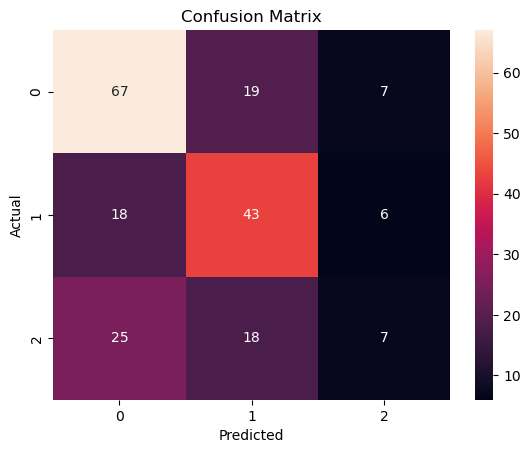

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Define your features and labels
X = X_labeled  # features
y = y # target
le = LabelEncoder()
# # y encoded
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = pd.DataFrame(y_encoded, index=X_labeled.index, columns=['semaforo_encoded'])

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 3: Train Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 4: Predictions
y_pred = clf.predict(X_test)

# Step 5: Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 6: Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

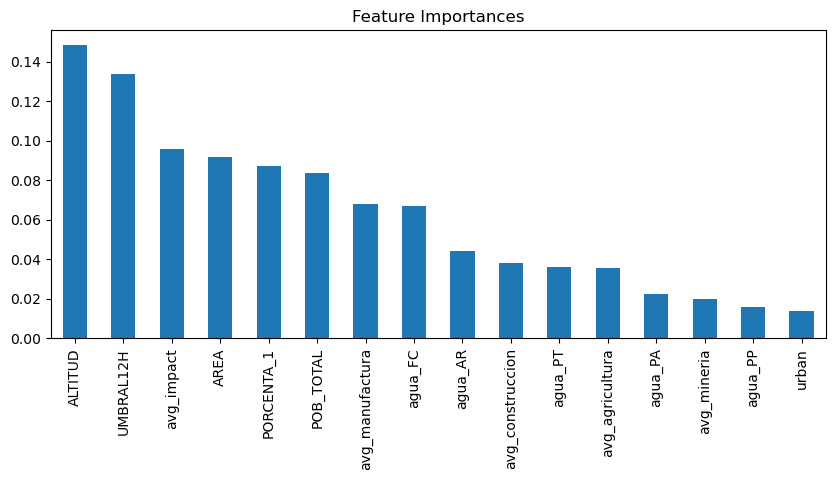

In [130]:
import pandas as pd

feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind="bar", figsize=(10, 4), title="Feature Importances")
plt.show()

In [117]:
X_labeled.head()

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,urban,agua_AR,agua_FC,agua_PA,agua_PT,agua_PP,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,avg_mineria
CVEGEO,,,,,,,,,,,,,,,,
1001,6.110137,0.749986,0.198225,-0.882390,-0.349543,2.417883,17.848848,11.985927,0.121758,6.362337,-0.153224,0.759083,0.582820,1.854487,1.700073,-0.082247
1002,0.003385,0.886615,-0.127084,-0.826000,-0.391276,-0.436637,-0.475733,2.470411,-0.215260,2.143901,-0.153224,0.783009,-0.171063,0.079724,-0.298491,-0.157249
1003,0.049071,0.639561,0.071335,-0.809529,-0.625749,-0.436637,0.933850,1.861861,-0.215260,0.737756,-0.153224,-0.058838,-0.063365,-0.115531,-0.263448,-0.119748
1004,-0.231616,0.810251,-0.343783,-1.022208,-0.475675,-0.436637,1.537957,0.202178,-0.215260,0.456527,-0.153224,0.843405,-0.171063,-0.325807,-0.348964,-0.157249
1005,0.536813,0.772419,-0.149788,-0.865871,-0.460283,2.417883,6.370814,1.806538,-0.215260,4.112504,-0.153224,0.020183,-0.063365,1.757149,3.360671,3.817856


In [119]:
y_encoded

,semaforo_encoded,0
CVEGEO,,
1001,1.0,NaN
1002,2.0,NaN
1003,1.0,NaN
1004,1.0,NaN
1005,1.0,NaN
...,...,...
31092,NaN,0.0
31098,NaN,0.0
31103,NaN,2.0
